In [16]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz


RESULTS_FOLDER = 'smile_osa_results'

Found 18 patient result files. Processing...


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_65973/3150653192.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(



Plot successfully saved to 'patient_event_totals_by_id.png'


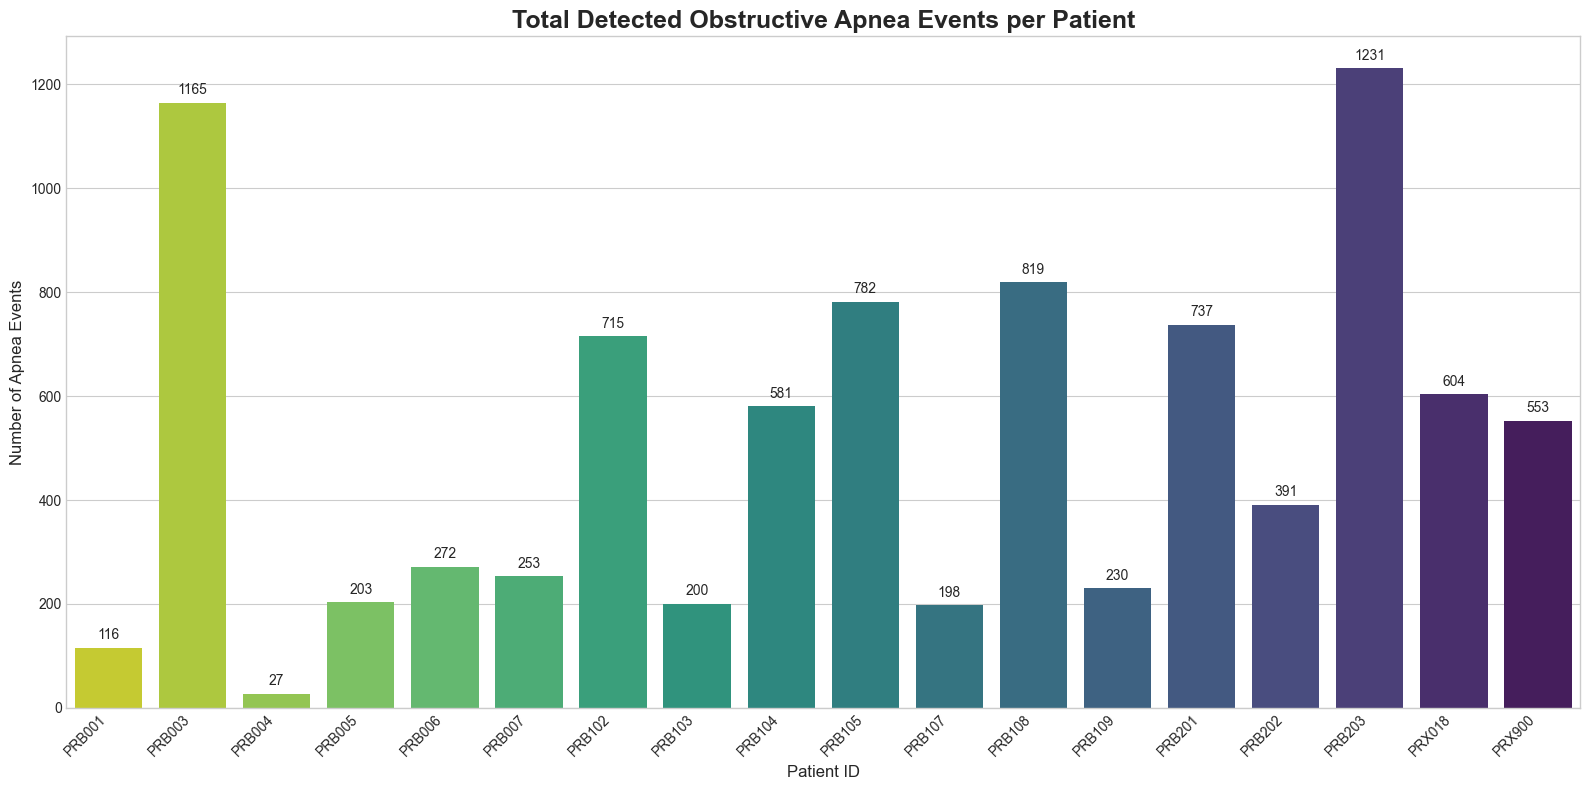

In [17]:

def plot_total_events_per_patient(results_folder, output_filename="patient_event_totals_by_id.png"):
    """
    Finds all patient OSA result CSVs in a folder, counts the events for each,
    and generates a bar plot summarizing the totals, ordered by Patient ID.

    Args:
        results_folder (str): The path to the folder containing the _osa.csv files.
        output_filename (str): The filename for the saved plot image.
    """
    # --- 1. Find and process all result files ---
    search_pattern = os.path.join(results_folder, "*_osa.csv")
    result_files = glob.glob(search_pattern)

    if not result_files:
        print(f"Error: No '*_osa.csv' files found in the folder: '{results_folder}'")
        return

    print(f"Found {len(result_files)} patient result files. Processing...")

    patient_events = {}
    for file_path in result_files:
        filename = os.path.basename(file_path)
        patient_id = filename.split('_osa.csv')[0]

        try:
            df = pd.read_csv(file_path)
            event_count = len(df)
            patient_events[patient_id] = event_count
        except pd.errors.EmptyDataError:
            patient_events[patient_id] = 0
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")

    # --- 2. Prepare data for plotting ---
    if not patient_events:
        print("No valid patient data to plot.")
        return

    events_df = pd.DataFrame(list(patient_events.items()), columns=['PatientID', 'EventCount'])

    # <<< FIX: Sort the DataFrame by PatientID instead of EventCount
    events_df_sorted = events_df.sort_values('PatientID', ascending=True)

    # --- 3. Create and customize the plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 8))

    ax = sns.barplot(
        x='PatientID',
        y='EventCount',
        data=events_df_sorted,
        palette='viridis_r' # Reversed palette for variety
    )

    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), '.0f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center',
            va = 'center',
            xytext = (0, 9),
            textcoords = 'offset points'
        )

    plt.title('Total Detected Obstructive Apnea Events per Patient', fontsize=18, fontweight='bold')
    plt.xlabel('Patient ID', fontsize=12)
    plt.ylabel('Number of Apnea Events', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # --- 4. Save and show the plot ---
    # I've updated the output filename to reflect the new sorting
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot successfully saved to '{output_filename}'")
    
    plt.show()



plot_total_events_per_patient(results_folder=RESULTS_FOLDER)

Found 18 patient result files. Aggregating data...
Total events from all patients: 9077

Plot successfully saved to 'nightly_stacked_distribution.png'


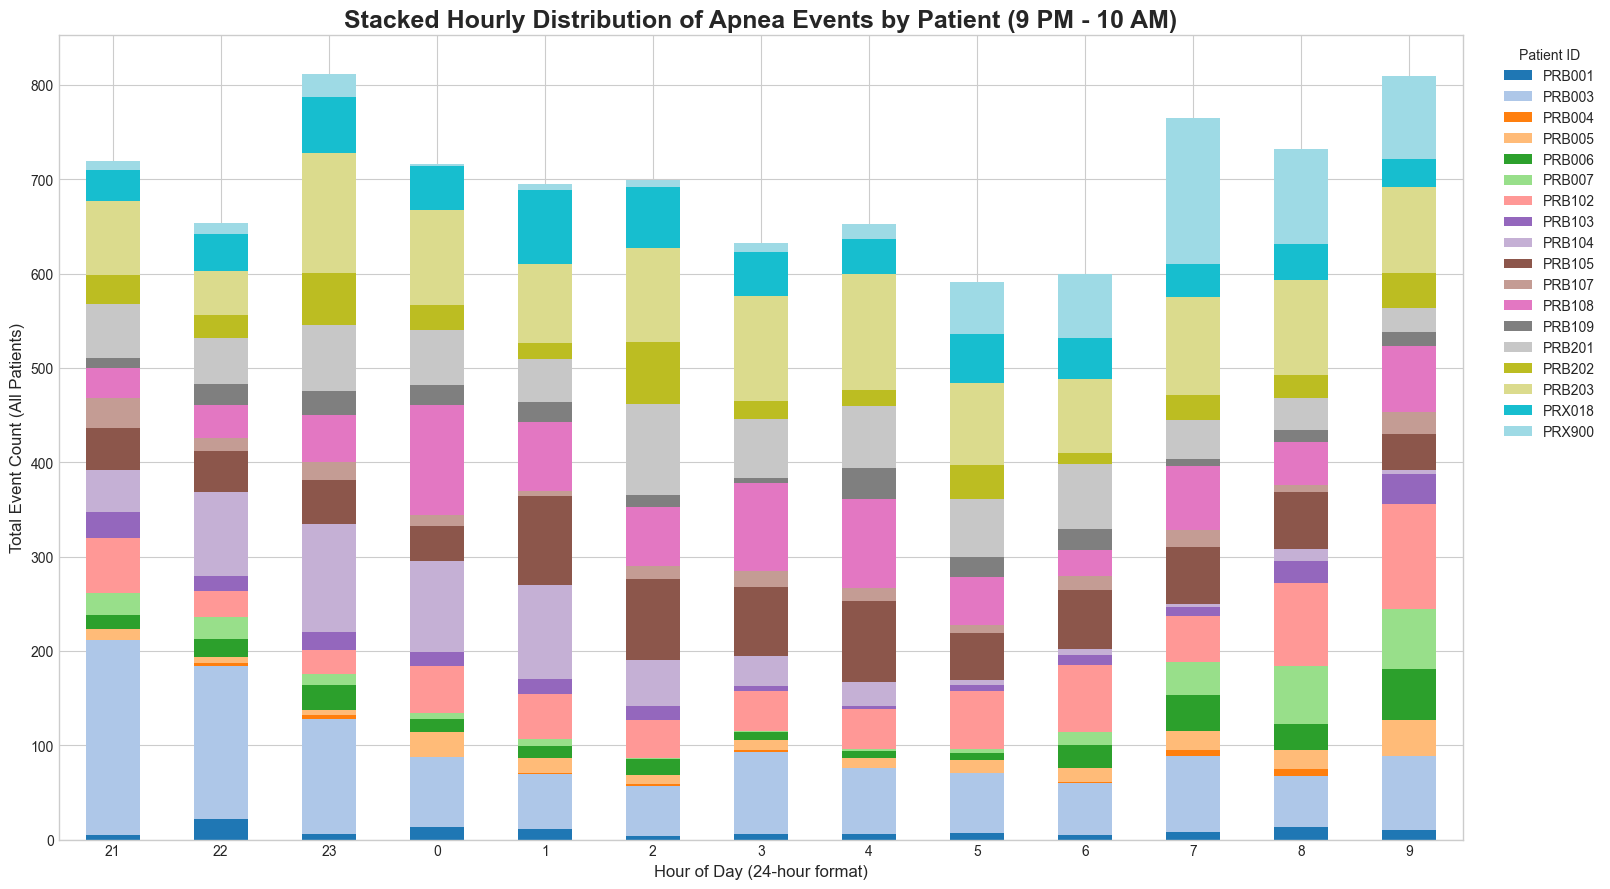

In [18]:
def plot_stacked_hourly_distribution(results_folder, output_filename="nightly_stacked_distribution.png"):
    """
    Aggregates all patient OSA events and plots their hourly distribution
    as a stacked bar chart, showing each patient's contribution.

    Args:
        results_folder (str): The path to the folder containing the _osa.csv files.
        output_filename (str): The filename for the saved plot image.
    """
    # --- 1. Find and aggregate all result files, adding a PatientID column ---
    search_pattern = os.path.join(results_folder, "*_osa.csv")
    result_files = glob.glob(search_pattern)

    if not result_files:
        print(f"Error: No '*_osa.csv' files found in the folder: '{results_folder}'")
        return

    print(f"Found {len(result_files)} patient result files. Aggregating data...")

    all_events_df_list = []
    for file_path in result_files:
        try:
            df = pd.read_csv(file_path)
            if not df.empty:
                # Extract patient prefix and add it as a new column
                filename = os.path.basename(file_path)
                patient_id = filename.split('_osa.csv')[0]
                df['PatientID'] = patient_id
                all_events_df_list.append(df)
        except pd.errors.EmptyDataError:
            continue
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")

    if not all_events_df_list:
        print("No events found across all patient files. Nothing to plot.")
        return

    combined_df = pd.concat(all_events_df_list, ignore_index=True)
    print(f"Total events from all patients: {len(combined_df)}")

    # --- 2. Prepare data for stacking ---
    # Extract the hour from the timestamp
    combined_df['hour'] = pd.to_datetime(combined_df['time'], format='%H:%M:%S').dt.hour

    # Group by both hour and patient to get counts for each patient within each hour
    hourly_patient_counts = combined_df.groupby(['hour', 'PatientID']).size().reset_index(name='EventCount')

    # Pivot the data to get a format suitable for a stacked bar chart:
    # Rows will be hours, columns will be patients, values will be the event counts.
    pivoted_df = hourly_patient_counts.pivot(index='hour', columns='PatientID', values='EventCount').fillna(0)

    # --- 3. Order the hours correctly for the nightly window ---
    nightly_hours_order = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    # Reindex the DataFrame to ensure all hours are present and in the correct order
    pivoted_df = pivoted_df.reindex(nightly_hours_order, fill_value=0)

    # --- 4. Create and customize the plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Use pandas' built-in plotting for easy stacking
    ax = pivoted_df.plot(
        kind='bar',
        stacked=True,
        figsize=(18, 9),
        # Use a colormap that provides many distinct colors
        colormap='tab20' 
    )

    plt.title('Stacked Hourly Distribution of Apnea Events by Patient (9 PM - 10 AM)', fontsize=18, fontweight='bold')
    plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
    plt.ylabel('Total Event Count (All Patients)', fontsize=12)
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=0)
    
    # Move the legend outside of the plot area to prevent it from covering the bars
    plt.legend(title='Patient ID', bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for the legend

    # --- 5. Save and show the plot ---
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot successfully saved to '{output_filename}'")
    
    plt.show()
plot_stacked_hourly_distribution(results_folder=RESULTS_FOLDER)

In [26]:

def load_and_combine_raw_data(patient_id_prefix, data_root_folder):
    """
    Finds the patient's data folder using a prefix, loads all CSVs from the 
    'Respeck' subfolder, and concatenates them into a single, sorted DataFrame.
    """
    search_pattern = os.path.join(data_root_folder, f"{patient_id_prefix}*")
    matching_folders = glob.glob(search_pattern)
    
    if not matching_folders:
        print(f"  - ERROR: No data folder found starting with '{patient_id_prefix}'")
        return None
    
    patient_folder = matching_folders[0]
    respeck_folder = os.path.join(patient_folder, 'Respeck')

    if not os.path.isdir(respeck_folder):
        print(f"  - ERROR: No 'Respeck' subfolder found in '{patient_folder}'")
        return None

    csv_files = glob.glob(os.path.join(respeck_folder, '*.csv'))
    
    if not csv_files:
        print(f"  - ERROR: No CSV files found in '{respeck_folder}'")
        return None
        
    print(f"  - Found {len(csv_files)} raw data files for patient {patient_id_prefix}. Loading...")

    df_list = [pd.read_csv(file) for file in csv_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df.sort_values(by='interpolatedPhoneTimestamp', inplace=True)
    
    return combined_df

def plot_event_waveforms_for_patient(patient_id_prefix, event_df, raw_df):
    """
    Processes the loaded data and generates plots for each event.
    """
    output_dir = f"{patient_id_prefix}_event_plots"
    os.makedirs(output_dir, exist_ok=True)
    print(f"  - Plots will be saved to the '{output_dir}' directory.")

    raw_df['datetime'] = pd.to_datetime(raw_df['interpolatedPhoneTimestamp'], unit='ms', utc=True)
    scotland_tz = pytz.timezone('Europe/London')
    raw_df['datetime'] = raw_df['datetime'].dt.tz_convert(scotland_tz)
    raw_df.set_index('datetime', inplace=True)

    for index, event_row in event_df.iterrows():
        event_time_str = f"{event_row['date']} {event_row['time']}"
        event_time = pd.to_datetime(event_time_str).tz_localize(scotland_tz)

        start_window = event_time - pd.Timedelta(minutes=1)
        end_window = event_time + pd.Timedelta(minutes=1)

        data_segment = raw_df.loc[start_window:end_window]

        if data_segment.empty:
            print(f"    - WARNING: No raw data found for event at {event_time_str}. Skipping plot.")
            continue

        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(15, 6))
        plt.plot(data_segment.index, data_segment['breathingSignal'], label='Breathing Signal', color='royalblue')
        plt.axvline(x=event_time, color='red', linestyle='--', linewidth=2, label=f'Apnea Event Detected\n({event_time.strftime("%H:%M:%S")})')
        plt.title(f"Patient {patient_id_prefix} - Breathing Signal Around Event {index + 1}", fontsize=16, fontweight='bold')
        plt.xlabel("Time (Scotland Time)", fontsize=12)
        plt.ylabel("Breathing Signal Amplitude", fontsize=12)
        plt.legend()
        plt.tight_layout()

        plot_filename = os.path.join(output_dir, f"event_{index + 1}_{event_time.strftime('%Y%m%d_%H%M%S')}.png")
        plt.savefig(plot_filename, dpi=150)
        plt.close()

    print(f"  - Finished plotting. {len(event_df)} plots have been saved.")


def main():
    # --- Configuration ---
    RESULTS_FOLDER = "smile_osa_results"
    DATA_ROOT_FOLDER = "../data/Smile"

    # <<< MODIFIED: Specify the single patient prefix to plot
    patient_id_prefix = "PRB001" 
    
    # --- Construct the path to the specific event file ---
    event_file_path = os.path.join(RESULTS_FOLDER, f"{patient_id_prefix}_osa.csv")

    print(f"\n--- Processing a single patient: {patient_id_prefix} ---")

    # --- 1. Load the detected event times ---
    try:
        event_df = pd.read_csv(event_file_path)
        if event_df.empty:
            print("  - No events in result file. Nothing to plot.")
            return
        print(f"  - Found {len(event_df)} events in {os.path.basename(event_file_path)}.")
    except Exception as e:
        print(f"  - ERROR: Could not read event file {event_file_path}: {e}")
        return

    # --- 2. Load the corresponding raw sensor data ---
    raw_df = load_and_combine_raw_data(patient_id_prefix, DATA_ROOT_FOLDER)
    
    if raw_df is None or raw_df.empty:
        print(f"  - Could not load raw data for {patient_id_prefix}. Aborting.")
        return

    # --- 3. Generate plots for this patient ---
    plot_event_waveforms_for_patient(patient_id_prefix, event_df, raw_df)

if __name__ == "__main__":
    main()


--- Processing a single patient: PRB001 ---
  - Found 116 events in PRB001_osa.csv.
  - Found 60 raw data files for patient PRB001. Loading...
  - Plots will be saved to the 'PRB001_event_plots' directory.
  - Finished plotting. 116 plots have been saved.



Processing patient: PRB005

Processing patient: PRB202

Processing patient: PRB107

Processing patient: PRB203

Processing patient: PRB004

Processing patient: PRX018

Processing patient: PRB201

Processing patient: PRB105

Processing patient: PRB006

Processing patient: PRB007

Processing patient: PRB104

Processing patient: PRB108

Processing patient: PRB109

Processing patient: PRB003

Processing patient: PRB001
  - No diary file found for PRB001. Skipping.

Processing patient: PRB102

Processing patient: PRX900

Processing patient: PRB103

--- Generating Plots ---
Saved box plot to 'boxplot_diary_vs_events.png'


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_65973/218080664.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


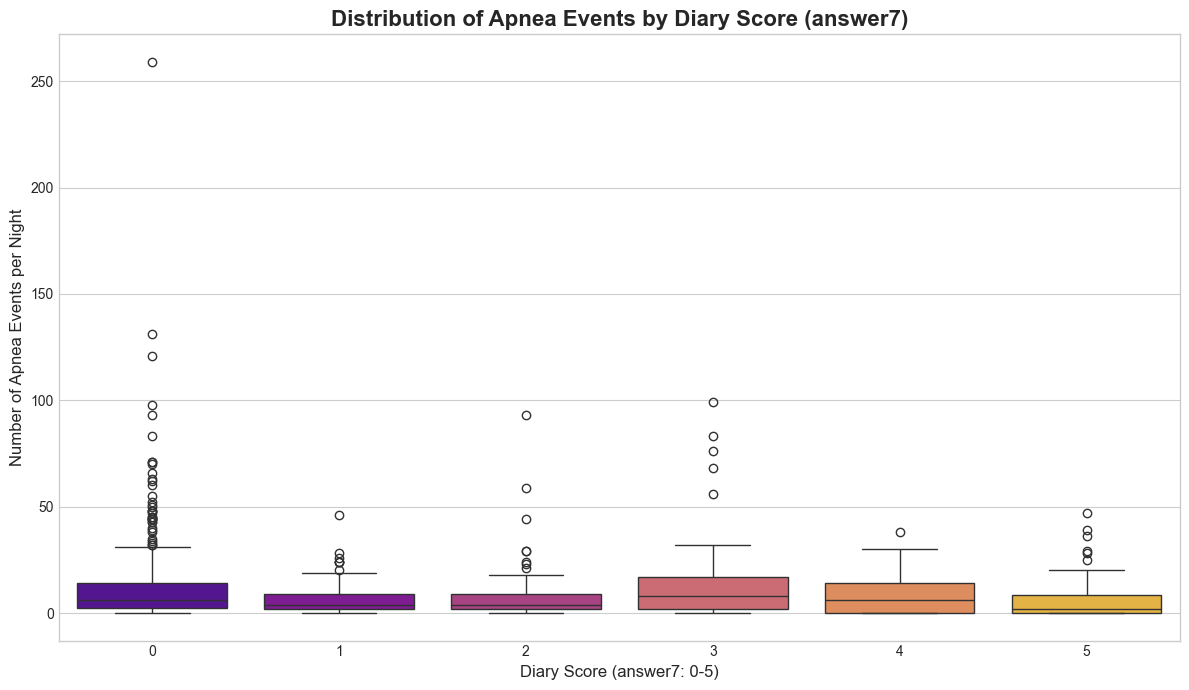

Saved scatter plot to 'scatterplot_diary_vs_events.png'


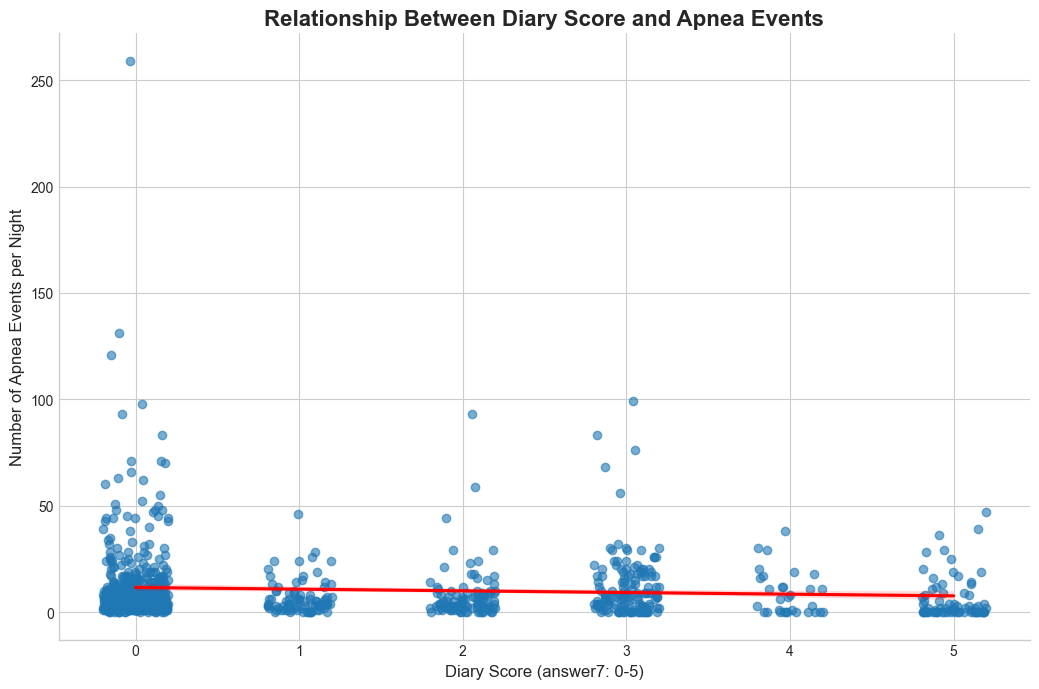

In [28]:
# plot_diary_correlation.py

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

def analyze_diary_vs_events(results_folder, data_root_folder):
    """
    Loads diary scores and apnea event counts, merges them, and creates
    visualizations to show their relationship.
    """
    # --- 1. Find all patient prefixes from the results folder ---
    result_files = glob.glob(os.path.join(results_folder, "*_osa.csv"))
    if not result_files:
        print(f"Error: No result files found in '{results_folder}'.")
        return

    all_daily_data = []
    scotland_tz = pytz.timezone('Europe/London')
    
    # --- 2. Loop through each patient to process and merge data ---
    for event_file_path in result_files:
        patient_id_prefix = os.path.basename(event_file_path).split('_osa.csv')[0]
        print(f"\nProcessing patient: {patient_id_prefix}")

        # --- A. Load and process APNEA EVENT counts per day ---
        try:
            event_df = pd.read_csv(event_file_path)
            if event_df.empty:
                apnea_counts_per_day = pd.DataFrame(columns=['date', 'EventCount'])
            else:
                # Group by date and count the number of events
                apnea_counts_per_day = event_df.groupby('date').size().reset_index(name='EventCount')
        except Exception as e:
            print(f"  - Could not process apnea file {event_file_path}: {e}")
            continue

        # --- B. Load and process DIARY scores per day ---
        diary_search = glob.glob(os.path.join(data_root_folder, f"{patient_id_prefix}*/Diary/*.csv"))
        if not diary_search:
            print(f"  - No diary file found for {patient_id_prefix}. Skipping.")
            continue
        diary_file_path = diary_search[0]

        try:
            diary_df = pd.read_csv(diary_file_path)
            # Convert Unix timestamp (seconds) to a date in the correct timezone
            diary_df['datetime'] = pd.to_datetime(diary_df['timestamp'], unit='s', utc=True).dt.tz_convert(scotland_tz)
            diary_df['date'] = diary_df['datetime'].dt.strftime('%Y-%m-%d')
            # Keep only the relevant columns
            diary_scores_per_day = diary_df[['date', 'answer7']].rename(columns={'answer7': 'DiaryScore'})
        except Exception as e:
            print(f"  - Could not process diary file {diary_file_path}: {e}")
            continue

        # --- C. Merge the two datasets for this patient ---
        # Use an outer merge to keep all days from both datasets
        daily_summary = pd.merge(apnea_counts_per_day, diary_scores_per_day, on='date', how='outer')
        daily_summary['PatientID'] = patient_id_prefix
        
        # Fill missing values (e.g., a day with a diary score but no apnea events) with 0
        daily_summary.fillna(0, inplace=True)
        
        all_daily_data.append(daily_summary)

    # --- 3. Create a final master DataFrame ---
    if not all_daily_data:
        print("No valid data could be merged. Aborting.")
        return

    final_df = pd.concat(all_daily_data, ignore_index=True)
    # Ensure score columns are integers for correct plotting
    final_df['EventCount'] = final_df['EventCount'].astype(int)
    final_df['DiaryScore'] = final_df['DiaryScore'].astype(int)

    print("\n--- Generating Plots ---")

    # --- PLOT 1: Box Plot (Best for showing distributions) ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    sns.boxplot(
        x='DiaryScore',
        y='EventCount',
        data=final_df,
        palette='plasma'
    )
    plt.title('Distribution of Apnea Events by Diary Score (answer7)', fontsize=16, fontweight='bold')
    plt.xlabel('Diary Score (answer7: 0-5)', fontsize=12)
    plt.ylabel('Number of Apnea Events per Night', fontsize=12)
    plt.tight_layout()
    plt.savefig("boxplot_diary_vs_events.png", dpi=300)
    print("Saved box plot to 'boxplot_diary_vs_events.png'")
    plt.show()

    # --- PLOT 2: Scatter Plot with Jitter and Trend Line ---
    # lmplot is great for this as it handles jitter and regression line automatically
    sns.lmplot(
        x='DiaryScore',
        y='EventCount',
        data=final_df,
        x_jitter=.2,  # Add horizontal jitter to see overlapping points
        height=7,
        aspect=1.5,
        scatter_kws={'alpha':0.6}, # Make points slightly transparent
        line_kws={'color': 'red'} # Make trend line stand out
    )
    plt.title('Relationship Between Diary Score and Apnea Events', fontsize=16, fontweight='bold')
    plt.xlabel('Diary Score (answer7: 0-5)', fontsize=12)
    plt.ylabel('Number of Apnea Events per Night', fontsize=12)
    plt.tight_layout()
    plt.savefig("scatterplot_diary_vs_events.png", dpi=300)
    print("Saved scatter plot to 'scatterplot_diary_vs_events.png'")
    plt.show()


if __name__ == "__main__":
    RESULTS_FOLDER = "smile_osa_results"
    DATA_ROOT_FOLDER = "../data/Smile"
    analyze_diary_vs_events(RESULTS_FOLDER, DATA_ROOT_FOLDER)